In [55]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
from scipy.stats import norm
import pandas

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
Psun[Psun==inf] = 0.0
pops[1] = 30.0
weights = pops#*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights /= sum(weights)


ne = 1000
Evals = linspace(0.001,150.0,ne)

A = 131
m_chi = 20.0
sigma_p = 1.0e-45
v_min = MinimumWIMPSpeed(Evals,A,m_chi)

# Halo
gmin_Iso = 1.0*gvmin_Isotropic(v_min,day,GravFocus=False)
gmin_Saus = 1.0*gvmin_Triaxial(v_min,day,sig_beta,GravFocus=False)

# Shards
v_s = velocities[0,:]
sig_s = dispersions[0,:]
gmin_sub = weights[0]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=False)
shard_label = ['S1']
for i in range(1,nshards):
    if names[i].endswith('a'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        gmin_sub1 = weights[i]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=False)

        v_s = velocities[i+1,:]
        sig_s = dispersions[i+1,:]
        gmin_sub1 += weights[i]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=False)
        shard_label.append(names[i][:-1])
        
        gmin_sub = vstack((gmin_sub,gmin_sub1))
        
    elif not names[i].endswith('b'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        gmin_sub1 = weights[i]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s,GravFocus=False)
        shard_label.append(names[i])
      
        gmin_sub = vstack((gmin_sub,gmin_sub1))

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



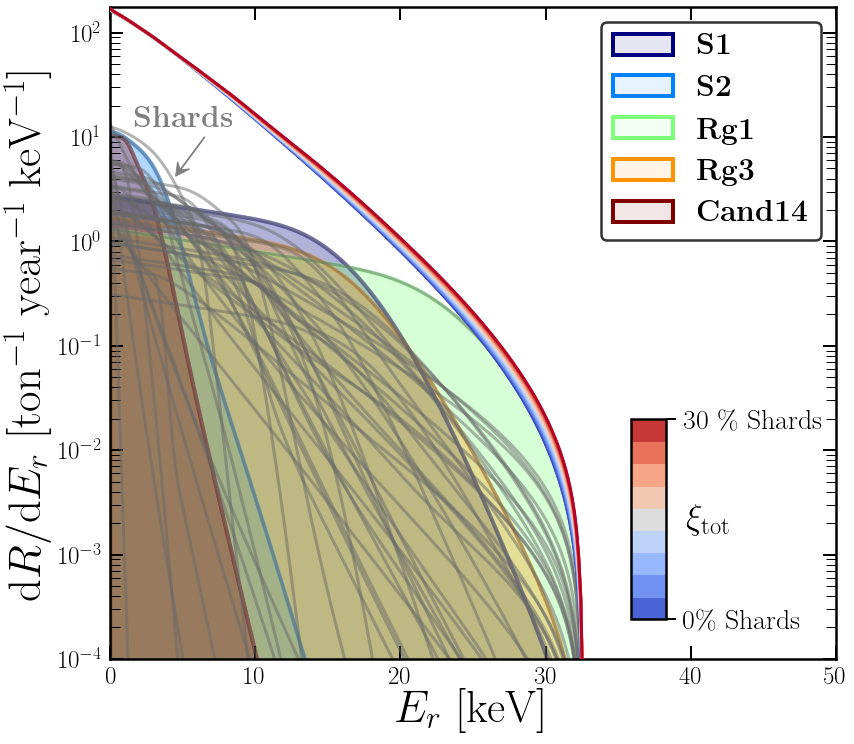

In [58]:
nshards = shape(shard_label)[0]


# Figure setup
xlab = r"$E_r$ [keV]"
ylab = r'$\textrm{d}R/\textrm{d}E_r$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]'
fig,ax = MySquarePlot(xlab,ylab)

# Smooth component
eta_saus = 0.2
gmin0 = (1-eta_saus)*gmin_Iso + eta_saus*gmin_Saus
dR0 = diffRecoilRate_SI(Evals,gmin0,A,sigma_p,m_chi,rho_0=0.55)

# Shards
dR = zeros(shape=(nshards,ne))
for i in range(0,nshards):
    dR[i,:] = diffRecoilRate_SI(Evals,gmin_sub[i,:],A,sigma_p,m_chi,rho_0=0.55)


# Shards with varying xi
n_xi = 10
xi_max = 0.35
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2 = (xi_vals[-1]*sum(dR,0)+(1.0-xi_vals[-1])*dR0)
y0 = (xi_vals[0]*sum(dR,0)+(1.0-xi_vals[0])*dR0)

dRs = sum(dR,0)
for i in range(0,n_xi):
    xi = xi_vals[i]
    plt.fill_between(Evals,(xi*dRs+(1-xi)*dR0),y2=y2,color=col[i,:],zorder=3)
    plt.plot(Evals,xi*dRs+(1-xi)*dR0,'-',color=col[i,:],linewidth=3,zorder=3)
    
    
# Range
plt.plot(Evals,dR0,'-',color=col[0,:],linewidth=3)
plt.plot(Evals,y2,'-',color=col[-1,:],linewidth=3)


Examples = ['S1','S2','Rg1','Rg3','Cand14']
nex = size(Examples)
col_ex = (cm.jet(linspace(0,1,nex)))
for i in range(0,size(Examples)):
    j = shard_label.index(Examples[i])
    plt.fill_between(Evals,dR[j,:],color=col_ex[i,:],lw=4,alpha=0.3,zorder=1) 
    plt.plot(Evals,dR[j,:],color=col_ex[i,:],lw=4,alpha=0.3,zorder=1) 
    plt.fill_between([-1,-1],[-1,-3],facecolor=col_alpha(col_ex[i,:]),edgecolor=col_ex[i,:],lw=4,label=r'{\bf '+Examples[i]+r'}',zorder=1)

# Plot individual streams
for i in range(0,nshards):
    plt.plot(Evals,dR[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=2) 

    
# Legend lines
leg = ax.legend(loc='upper right',fontsize=30,edgecolor='k')
leg.get_frame().set_linewidth(2.5)
 
    
# Plot fiddling
# Style
ax.set_xlim(left=0.0,right=50.0)
ax.set_ylim(bottom=1.0e-4)
plt.yscale('log')


plt.arrow(0.13, 0.8, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')
plt.gcf().text(0.15,0.74,r'{\bf Shards}',fontsize=30,color='gray')



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-15, -40, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.74,0.27,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_dRdE'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')